<a href="https://colab.research.google.com/github/ayussh176/Air-Quality-Index/blob/main/Air_quality_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing all Dependices library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

Current working directory: d:\aqi\model
Files in current directory: ['Air_quality_index.ipynb', 'AQI_data.csv']
✅ AQI_data.csv found!
Loading and preprocessing data...
✅ Data loaded successfully!
Dataset shape: (5811, 15)
Columns: ['RecordID', 'AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity', 'WindSpeed', 'RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions', 'HealthImpactScore', 'HealthImpactClass']
First few rows:
   RecordID         AQI        PM10       PM2_5         NO2        SO2  \
0         1  187.270059  295.853039   13.038560    6.639263  66.161150   
1         2  475.357153  246.254703    9.984497   16.318326  90.499523   
2         3  365.996971   84.443191   23.111340   96.317811  17.875850   
3         4  299.329242   21.020609   14.273403   81.234403  48.323616   
4         5   78.009320   16.987667  152.111623  121.235461  90.866167   

           O3  Temperature   Humidity  WindSpeed  RespiratoryCases  \
0   54.624280     5.150335  84.424

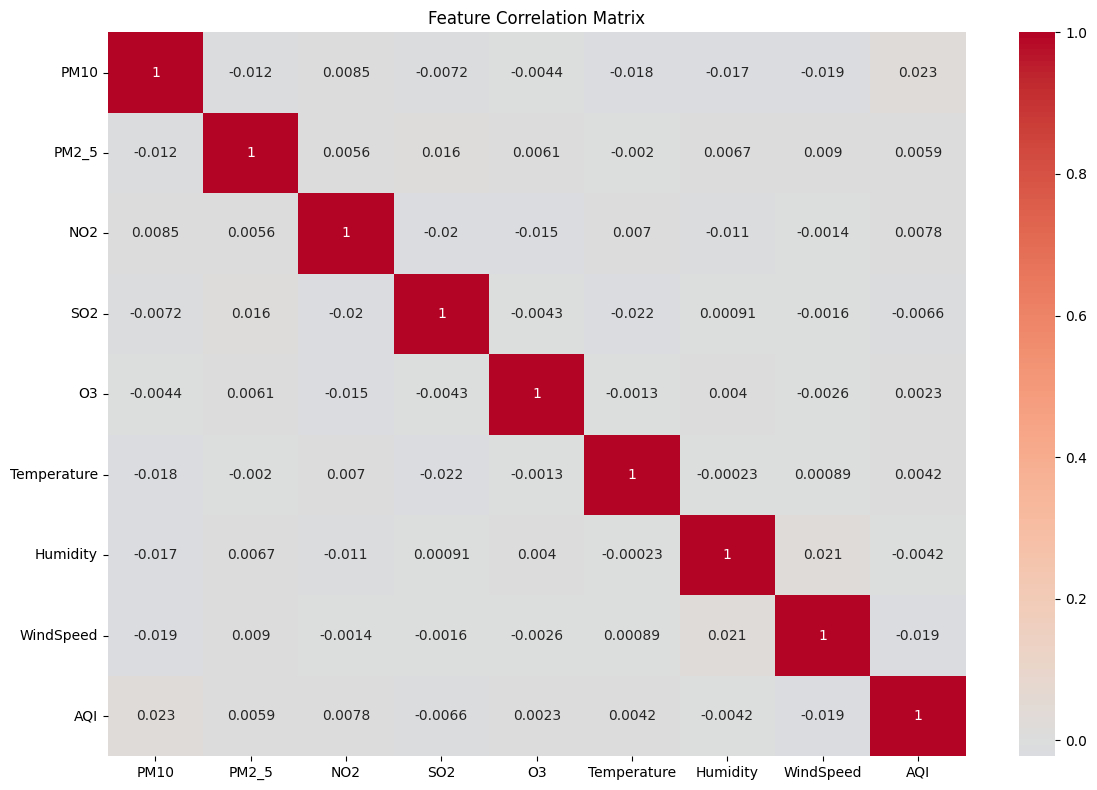

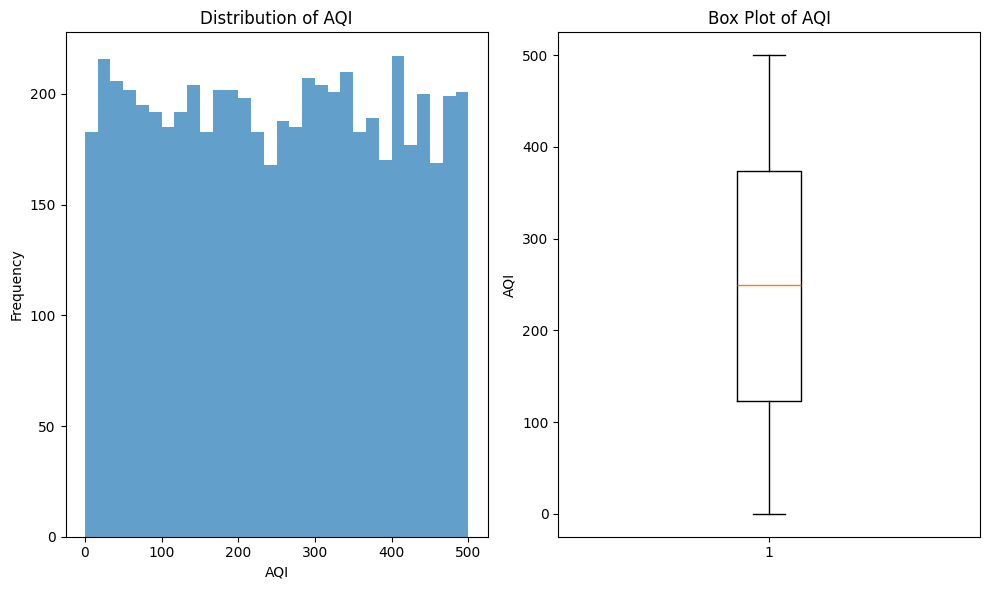


Feature correlations with AQI:
PM10: 0.023
WindSpeed: 0.019
NO2: 0.008
SO2: 0.007
PM2_5: 0.006
Humidity: 0.004
Temperature: 0.004
O3: 0.002

Splitting data: 80% train, 20% test

=== Training Multiple Models ===

Training Linear Regression...
CV RMSE: 144.382 (+/- 4.398)

Training Random Forest...
CV RMSE: 146.995 (+/- 3.255)

Training Gradient Boosting...
CV RMSE: 145.869 (+/- 3.959)

Training Support Vector Regression...
CV RMSE: 144.333 (+/- 4.341)

=== Hyperparameter Tuning ===
Best model from CV: Support Vector Regression

=== Model Evaluation ===
Test Set Performance:
RMSE: 147.045
MAE: 128.717
R² Score: -0.002


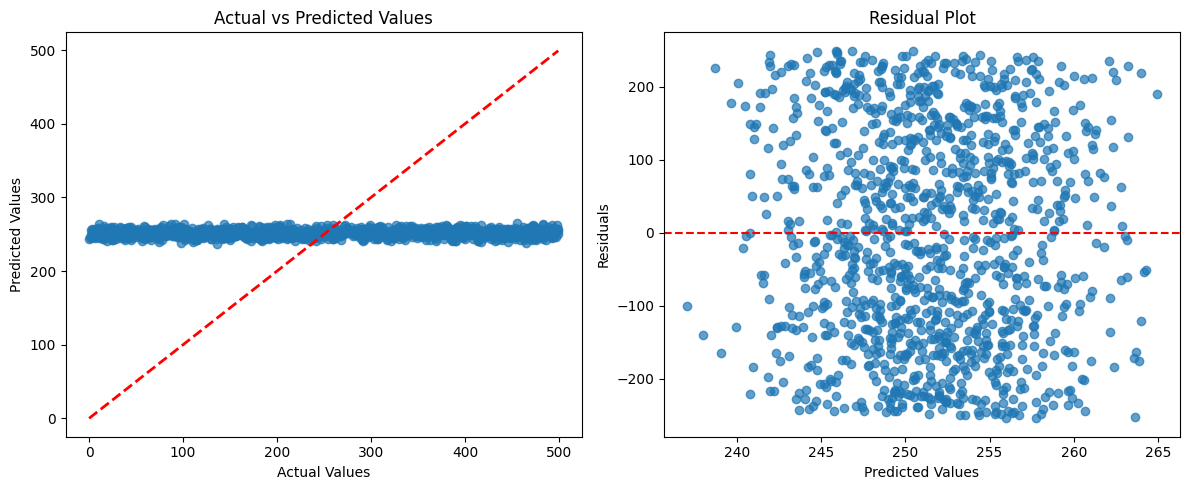

✅ Model saved successfully to model\Air_quality_index.pkl


In [2]:
class AirQualityMLModel:
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        self.feature_selector = None
        self.best_model = None
        self.feature_names = None

    def load_and_preprocess_data(self, file_path):
        """Load and preprocess the air quality dataset"""
        print("Loading and preprocessing data...")

        # Load data
        try:
            df = pd.read_csv(file_path)
            print("✅ Data loaded successfully!")
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            return None, None, None

        # Display basic info
        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"First few rows:")
        print(df.head())

        # Handle missing values
        print(f"Missing values before cleaning: {df.isnull().sum().sum()}")
        df = df.dropna()
        print(f"Shape after removing missing values: {df.shape}")

        # Auto-detect columns based on your dataset structure
        # Common air quality column names to look for
        possible_features = ['PM10', 'PM2_5', 'PM2.5', 'NO2', 'SO2', 'O3',
                           'Temperature', 'Temp', 'Humidity', 'WindSpeed',
                           'Wind_Speed', 'Wind Speed', 'Pressure']

        possible_targets = ['AQI', 'Air_Quality_Index', 'Air Quality Index']

        # Find actual column names (case insensitive)
        available_cols = df.columns.tolist()
        feature_columns = []
        target_column = None

        # Match feature columns
        for col in available_cols:
            for possible in possible_features:
                if col.lower().replace('_', '').replace(' ', '') == possible.lower().replace('_', '').replace(' ', ''):
                    feature_columns.append(col)
                    break

        # Match target column
        for col in available_cols:
            for possible in possible_targets:
                if col.lower().replace('_', '').replace(' ', '') == possible.lower().replace('_', '').replace(' ', ''):
                    target_column = col
                    break

        # If no matches found, use all numeric columns
        if not feature_columns:
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            # Remove ID columns and target column
            feature_columns = [col for col in numeric_cols
                             if not col.lower().startswith(('id', 'record'))
                             and col != target_column]

        # If no target found, use first numeric column or ask user
        if not target_column:
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            if numeric_cols:
                target_column = numeric_cols[0]  # Use first numeric column
                feature_columns = [col for col in feature_columns if col != target_column]

        print(f"🎯 Target variable: {target_column}")
        print(f"📊 Feature variables: {feature_columns}")

        if not target_column or not feature_columns:
            print("❌ Could not identify suitable columns. Please check your data.")
            return None, None, None

        X = df[feature_columns]
        y = df[target_column]

        self.feature_names = feature_columns

        return X, y, df

    def exploratory_data_analysis(self, X, y, df):
        """Perform exploratory data analysis"""
        print("\n=== Exploratory Data Analysis ===")

        # Basic statistics
        print("\nBasic Statistics:")
        print(df.describe())

        # Correlation analysis
        plt.figure(figsize=(12, 8))
        correlation_matrix = df[self.feature_names + [y.name]].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

        # Distribution of target variable
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.hist(y, bins=30, alpha=0.7)
        plt.title(f'Distribution of {y.name}')
        plt.xlabel(y.name)
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        plt.boxplot(y)
        plt.title(f'Box Plot of {y.name}')
        plt.ylabel(y.name)
        plt.tight_layout()
        plt.show()

        # Feature importance using correlation
        correlations = correlation_matrix[y.name].drop(y.name).abs().sort_values(ascending=False)
        print(f"\nFeature correlations with {y.name}:")
        for feature, corr in correlations.items():
            print(f"{feature}: {corr:.3f}")

    def prepare_data(self, X, y, test_size=0.2, random_state=42):
        """Split and scale the data"""
        print(f"\nSplitting data: {100*(1-test_size):.0f}% train, {100*test_size:.0f}% test")

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test

    def feature_selection(self, X_train, y_train, k=5):
        """Select top k features"""
        print(f"\nSelecting top {k} features...")

        self.feature_selector = SelectKBest(score_func=f_regression, k=k)
        X_train_selected = self.feature_selector.fit_transform(X_train, y_train)

        # Get selected feature names
        selected_features = [self.feature_names[i] for i in self.feature_selector.get_support(indices=True)]
        print(f"Selected features: {selected_features}")

        return X_train_selected, selected_features

    def train_models(self, X_train, y_train):
        """Train multiple ML models"""
        print("\n=== Training Multiple Models ===")

        # Define models
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'Support Vector Regression': SVR(kernel='rbf')
        }

        # Train and evaluate each model using cross-validation
        results = {}

        for name, model in models.items():
            print(f"\nTraining {name}...")

            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                      scoring='neg_mean_squared_error')
            cv_rmse = np.sqrt(-cv_scores)

            # Train on full training set
            model.fit(X_train, y_train)

            results[name] = {
                'model': model,
                'cv_rmse_mean': cv_rmse.mean(),
                'cv_rmse_std': cv_rmse.std()
            }

            print(f"CV RMSE: {cv_rmse.mean():.3f} (+/- {cv_rmse.std() * 2:.3f})")

        self.models = results
        return results

    def hyperparameter_tuning(self, X_train, y_train):
        """Perform hyperparameter tuning for the best performing model"""
        print("\n=== Hyperparameter Tuning ===")

        # Find best model from cross-validation
        best_model_name = min(self.models.keys(),
                             key=lambda x: self.models[x]['cv_rmse_mean'])
        print(f"Best model from CV: {best_model_name}")

        # Hyperparameter grids
        param_grids = {
            'Random Forest': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            },
            'Gradient Boosting': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
        }

        if best_model_name in param_grids:
            print(f"Tuning hyperparameters for {best_model_name}...")

            base_model = self.models[best_model_name]['model'].__class__()

            grid_search = GridSearchCV(
                base_model,
                param_grids[best_model_name],
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )

            grid_search.fit(X_train, y_train)

            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best CV score: {np.sqrt(-grid_search.best_score_):.3f}")

            self.best_model = grid_search.best_estimator_
        else:
            self.best_model = self.models[best_model_name]['model']

    def evaluate_model(self, X_test, y_test):
        """Evaluate the best model on test set"""
        print("\n=== Model Evaluation ===")

        # Make predictions
        y_pred = self.best_model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Test Set Performance:")
        print(f"RMSE: {rmse:.3f}")
        print(f"MAE: {mae:.3f}")
        print(f"R² Score: {r2:.3f}")

        # Plot predictions vs actual
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Actual vs Predicted Values')

        plt.subplot(1, 2, 2)
        residuals = y_test - y_pred
        plt.scatter(y_pred, residuals, alpha=0.7)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')

        plt.tight_layout()
        plt.show()

        return {'rmse': rmse, 'mae': mae, 'r2': r2}

    def feature_importance(self):
        """Display feature importance"""
        if hasattr(self.best_model, 'feature_importances_'):
            print("\n=== Feature Importance ===")

            # Get feature names (considering feature selection)
            if self.feature_selector:
                selected_features = [self.feature_names[i] for i in self.feature_selector.get_support(indices=True)]
            else:
                selected_features = self.feature_names

            importances = self.best_model.feature_importances_

            # Create DataFrame for better visualization
            feature_importance_df = pd.DataFrame({
                'feature': selected_features,
                'importance': importances
            }).sort_values('importance', ascending=False)

            print(feature_importance_df)

            # Plot feature importance
            plt.figure(figsize=(10, 6))
            sns.barplot(data=feature_importance_df, x='importance', y='feature')
            plt.title('Feature Importance')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()

    def predict_new_data(self, new_data):
        """Make predictions on new data"""
        # Scale the new data
        new_data_scaled = self.scaler.transform(new_data)

        # Apply feature selection if used
        if self.feature_selector:
            new_data_scaled = self.feature_selector.transform(new_data_scaled)

        # Make prediction
        prediction = self.best_model.predict(new_data_scaled)
        return prediction

# Google Colab Setup
def setup_colab():
    """Setup for Google Colab environment"""
    import os
    print("Current working directory:", os.getcwd())
    print("Files in current directory:", os.listdir('.'))

    # Check if the file exists
    if 'AQI_data.csv' in os.listdir('.'):
        print("✅ AQI_data.csv found!")
    else:
        print("❌ AQI_data.csv not found. Please upload the file.")
        return False
    return True

# Example usage for Google Colab
def main():
    # Setup Colab environment
    if not setup_colab():
        return

    # Initialize the model
    model = AirQualityMLModel()

    # Load and preprocess data
    X, y, df = model.load_and_preprocess_data('AQI_data.csv')

    # Exploratory Data Analysis
    model.exploratory_data_analysis(X, y, df)

    # Prepare data
    X_train, X_test, y_train, y_test = model.prepare_data(X, y)

    # Optional: Feature selection
    # X_train, selected_features = model.feature_selection(X_train, y_train, k=5)
    # X_test = model.feature_selector.transform(X_test)

    # Train models
    results = model.train_models(X_train, y_train)

    # Hyperparameter tuning
    model.hyperparameter_tuning(X_train, y_train)

    # Evaluate the best model
    metrics = model.evaluate_model(X_test, y_test)

    # Feature importance
    model.feature_importance()
    os.makedirs('model', exist_ok=True)
    model_path = os.path.join('model', 'Air_quality_index.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model.best_model, f)
    print(f"✅ Model saved successfully to {model_path}")

    # Example prediction on new data
    # new_data = [[pm10, pm2_5, no2, so2, o3, temp, humidity, windspeed]]
    # prediction = model.predict_new_data(new_data)
    # print(f"Predicted AQI: {prediction[0]:.2f}")

if __name__ == "__main__":
    main()